In [1]:
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Model
from keras.layers import Dense, Flatten,Input,Conv2D,MaxPooling2D
from keras.models import Sequential
import matplotlib.pyplot as plt
import json, codecs
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign

 99% 323M/325M [00:16<00:00, 21.5MB/s]
100% 325M/325M [00:16<00:00, 21.0MB/s]


In [3]:
! unzip "skin-cancer-malignant-vs-benign.zip" -d "/content/skin-cancer-malignant-vs-benign"

Streaming output truncated to the last 5000 lines.
  inflating: /content/skin-cancer-malignant-vs-benign/data/train/benign/420.jpg  
  inflating: /content/skin-cancer-malignant-vs-benign/data/train/benign/421.jpg  
  inflating: /content/skin-cancer-malignant-vs-benign/data/train/benign/422.jpg  
  inflating: /content/skin-cancer-malignant-vs-benign/data/train/benign/423.jpg  
  inflating: /content/skin-cancer-malignant-vs-benign/data/train/benign/424.jpg  
  inflating: /content/skin-cancer-malignant-vs-benign/data/train/benign/425.jpg  
  inflating: /content/skin-cancer-malignant-vs-benign/data/train/benign/426.jpg  
  inflating: /content/skin-cancer-malignant-vs-benign/data/train/benign/429.jpg  
  inflating: /content/skin-cancer-malignant-vs-benign/data/train/benign/43.jpg  
  inflating: /content/skin-cancer-malignant-vs-benign/data/train/benign/430.jpg  
  inflating: /content/skin-cancer-malignant-vs-benign/data/train/benign/431.jpg  
  inflating: /content/skin-cancer-malignant-vs-b

In [4]:
dataset_train = "/content/skin-cancer-malignant-vs-benign/train"
import pathlib
dataset_train = pathlib.Path(dataset_train)

In [5]:
print(dataset_train)

/content/skin-cancer-malignant-vs-benign/train


/content/skin-cancer-malignant-vs-benign/train/benign/1229.jpg


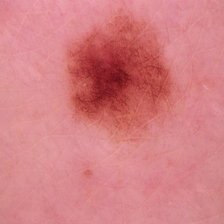

In [6]:
benign=list(dataset_train.glob('benign/*'))
print(benign[0])
PIL.Image.open(str(benign[0]))

/content/skin-cancer-malignant-vs-benign/train/malignant/828.jpg


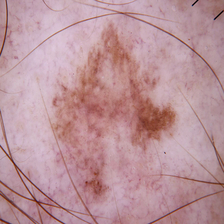

In [7]:
malignant = list(dataset_train.glob('malignant/*'))
print(malignant[0])
PIL.Image.open(str(malignant[0]))

In [8]:
img_height, img_width = 50,50
batch_size = 32
data_dir = r"/content/skin-cancer-malignant-vs-benign/train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
  validation_split=0.2,
  subset = "training",
  seed = 123,
  label_mode="categorical",
  image_size=(img_height, img_width),
  batch_size=None)


Found 2637 files belonging to 2 classes.
Using 2110 files for training.


In [9]:
## getting the validation dataset here using the keras library with same setting
data_test = r"/content/skin-cancer-malignant-vs-benign/test"
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_test,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=None)

Found 660 files belonging to 2 classes.
Using 132 files for validation.


In [10]:
import numpy as np
x_train = []
y_train = []
for i, j in train_ds:
  x_train.append(np.array(i))
  y_train.append(np.array(j))
x_train = np.array(x_train).reshape(-1,50,50, 3)
y_train = np.array(y_train)

In [11]:
import numpy as np
x_test = []
y_test = []
for i, j in val_ds:
  x_test.append(np.array(i))
  y_test.append(np.array(j))
x_test = np.array(x_test).reshape(-1,50,50,3)
y_test = np.array(y_test)

In [12]:
# convert df to np array and normalize data
x_train = x_train.astype("float32")/ 255.0
x_test = x_test.astype("float32")/ 255.0

In [13]:
# This is the size of our encoded representations
encoding_dim =128  # 128 floats -> compression of factor 2, assuming the input is 7500 floats

input_img =Input(shape=(7500,))
encoded1=Dense(3750, activation='relu')(input_img)
encoded2=Dense(1200, activation='relu')(encoded1)

encoded = Dense(encoding_dim,activation='relu')(encoded2)

decoded2 = Dense(1200, activation='relu')(encoded)
decoded1 = Dense(3750, activation='relu')(decoded2)
decoded = Dense(7500, activation='sigmoid')(decoded1)

autoencoder=keras.Model(input_img,decoded)

#create or separate the decoder model
encoder=keras.Model(input_img,encoded)
encoded_input=keras.Input(shape=(encoding_dim,))
decoder_layer_1=autoencoder.layers[-3](encoded_input)
decoder_layer_2=autoencoder.layers[-2](decoder_layer_1)
decoder_layer_3=autoencoder.layers[-1](decoder_layer_2)
decoder=keras.Model(encoded_input,decoder_layer_3)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7500)]            0         
                                                                 
 dense (Dense)               (None, 3750)              28128750  
                                                                 
 dense_1 (Dense)             (None, 1200)              4501200   
                                                                 
 dense_2 (Dense)             (None, 128)               153728    
                                                                 
 dense_3 (Dense)             (None, 1200)              154800    
                                                                 
 dense_4 (Dense)             (None, 3750)              4503750   
                                                                 
 dense_5 (Dense)             (None, 7500)              281325

In [14]:
x_train=x_train.reshape((len(x_train),np.prod(x_train.shape[1:])))
x_test=x_test.reshape((len(x_test),np.product(x_test.shape[1:])))
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(2110, 7500) (2110, 2) (132, 7500) (132,)


In [15]:
# This model maps an input to its reconstruction
autoencoder.compile(optimizer = "adam", loss = "binary_crossentropy")
autoencoder.fit(x_train,x_train,
                       epochs=50,
                       batch_size=32,
                       validation_data=(x_test,x_test))

Epoch 1/50
66/66 [==============================] - 11s 26ms/step - loss: 0.6443 - val_loss: 0.6307
Epoch 2/50
66/66 [==============================] - 1s 22ms/step - loss: 0.6259 - val_loss: 0.6172
Epoch 3/50
66/66 [==============================] - 2s 23ms/step - loss: 0.6208 - val_loss: 0.6170
Epoch 4/50
66/66 [==============================] - 1s 21ms/step - loss: 0.6163 - val_loss: 0.6085
Epoch 5/50
66/66 [==============================] - 2s 23ms/step - loss: 0.6129 - val_loss: 0.6073
Epoch 6/50
66/66 [==============================] - 1s 21ms/step - loss: 0.6115 - val_loss: 0.6035
Epoch 7/50
66/66 [==============================] - 1s 19ms/step - loss: 0.6102 - val_loss: 0.6076
Epoch 8/50
66/66 [==============================] - 1s 18ms/step - loss: 0.6090 - val_loss: 0.6020
Epoch 9/50
66/66 [==============================] - 1s 17ms/step - loss: 0.6068 - val_loss: 0.5994
Epoch 10/50
66/66 [==============================] - 1s 16ms/step - loss: 0.6048 - val_loss: 0.5983
Epoch 11

In [16]:
encoded_images=encoder.predict(x_test)
decoded_images=decoder.predict(encoded_images)
encoded_images_2=encoder.predict(x_train)
decoded_images_2=decoder.predict(encoded_images_2)

66/66 [==============================] - 0s 2ms/step


In [17]:
decoded_images=decoded_images.reshape(-1,50,50,3)

In [18]:
decoded_images.shape

(132, 50, 50, 3)

In [19]:
decoded_images_2=decoded_images_2.reshape(-1,50,50,3)


In [20]:
decoded_images_2.shape

(2110, 50, 50, 3)

In [21]:
#CNN Model
model=keras.Sequential()
model.add(Input(shape=(50,50,3)))
model.add(Conv2D(filters=6,kernel_size=5,strides=(1,1),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid'))
model.add(Conv2D(filters=16,kernel_size=3,strides=(1,1),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid'))
model.add(Flatten())
model.add(Dense(84,activation='relu'))
model.add(Dense(2,activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 6)         456       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 16)        880       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense_6 (Dense)             (None, 84)                1

In [27]:
model.compile(optimizer='adam',loss='Categorical_crossentropy',metrics=['accuracy'])

In [ ]:
from numpy.random.mtrand import shuffle
result=model.fit(decoded_images_2,
                 y=y_train,
                 shuffle='false',
                 epochs=10,
                 validation_data=(decoded_images,y_test)
)

In [29]:
#RESNET Model
resnet_m=Sequential()
pretrained_model=tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(50,50,3),
    pooling='avg',
    classes=2,
    weights='imagenet'
)
for i in pretrained_model.layers:
  i.trainable=False

94765736/94765736 [==============================] - 5s 0us/step


In [32]:
resnet_m=model.add(pretrained_model)
resnet_m.add(Flatten())
resnet_m.add(Dense(512,activation='relu'))
resnet_m.add(Dense(2,activation='softmax'))

ValueError: ignored

In [ ]:
resnet_m.compile(loss='Categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
hist=resnet_m.fit(
    x=decoded_images_2,
    y=y_train,
    epochs=5,
    validation_data=(decoded_images,y_test)
)